# SYSC4415 - Assignment 2

**TA: François Charih \<francois@charih.ca\>**

**Deadline: March 19th, 2023 @ 11:59PM**

## Learning objectives

1. Fine-tune pre-trained CNN architectures for a custom image classification challenge.

2. Evaluate the performance of machine learning models using different metrics (precision-recall curve, confusion matrices, *etc.*).

3. Get hands-on experience with modern machine learning and plotting libraries.

## Instructions

1. Give yourself plenty of time to complete the assignment (it could take you up to 8-10 hours if you are unfamiliar with Python and machine learning libraries). The models should not take more than 1h to fine-tune (my full notebook runs from start to end in a little under 40 minutes. Coding will be the most time-consuming. ⚠️**Do not wait to the last minute.** ⚠️

2. You must use the prescribed methods/functions/libraries mentioned, whenever specified. The functions you need are already imported for you in the appropriate sections. You can reorganize the imports and import the full packages instead of specific functions if you so desire. I imported the necessary function for you so that they are ready to be invoked without have to specify the full path to the functions with the dot operator (i.e. so that you invoke `function()` instead of `package.module.function()`).

3. Make sure to include comments for non-trivial code. It is okay to add some code cells, if you think it will give your code better readability/structure.

4. If you are unsure about something, clearly state your assumptions and complete the question based off these assumptions.

5. Be careful as you complete the assignment. There are several text-based questions to be answered in Markdown (text) cells. The questions are accompanied by the ❓ emoji. Your answers should be entered in the markdown cells with the 📝 emoji.

6. Submit your Notebook as both a `.ipynb` file that adopts this naming convention: *SYSC4415W23_A2_\<First Name\>_\<Last Name\>_\<StudentID\>.ipynb* on Brightspace. I should be able to run your code without errors.

7. Make sure you enable a GPU accelerator (in Runtime > Change runtime type) starting at Part 4 and that your training code uses it. GPU resources are limited, so it is recommended not to use the accelerator for prior steps.

8. All plots should be made with matplotlib and labeled properly (ie. include axis labels and legends).

## Context

It is 2030, and a new RNA virus named SARS-CoV-3 is wreaking havoc across the globe. Its death rate is estimated at 95%, making it one of the deadliest  respiratory viruses known to mankind. Fortunately, an Ottawa-based biotech company developed a nasally-delivered vaccine *Greenraza*™️ that can neutralize the virus in living patients. However, administrating the vaccine increases the risk of lung cancer by a whooping 60%. It is therefore vital that the drug be administered to infected patients only, not to patients infected with another respiratory virus such as the common cold or influenza. The virus cannot be detected through blood or breath analyses. It can only be detected by means of x-ray imaging.

Having heard of your newly developed expertise in deep learning, you have been tasked by the Ottawa Hospital with the design of a machine learning model capable of distinguishing patients infected with SARS-CoV-3 from patients that have pneumonia and non-infected patients. Healthy patients can be discharged, while patients with pneumonia must be isolated, but without being given *Greenraza*™️.

## Project initialization

Run the cells below to set-up the notebook (ie. download the dataset) and install the required external libraries.

In [2]:
# RUN THIS (downloads the dataset)
usingColab = False

if usingColab:
    ! rm -rf SYSC4415W23_A2_dataset SYSC4415W23_A2_dataset.zip
    ! wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment2/SYSC4415W23_A2_dataset.zip && unzip SYSC4415W23_A2_dataset.zip

In [3]:
# RUN THIS (installs external libraries)
if usingColab:
    !pip install timm
    !pip install git+https://github.com/nottombrown/imagenet_stubs
    !pip install torchstat

## Part 1: Preparing the dataset

The Ottawa Hospital has provided you with a dataset to develop your model. The dataset is available here. The dataset contains a folder containing a spreadsheet with metadata for each image in the dataset and a subfolder containing the 200x200 images (with random filenames).

In [4]:
from pandas import read_csv
from matplotlib.pyplot import bar, xlabel, ylabel, title, figure

**Step 1:** Using pandas' `read_csv` function, load the dataframe containing the image metadata (`dataset_metadata.csv`).

In [5]:
# Loads the image metadata into a pandas dataframe

# YOUR CODE HERE
if usingColab:
    csvPath = "SYSC4415W23_A2_dataset\\dataset_metadata.csv"
    datasetPath = "SYSC4415W23_A2_dataset\\"
else:
    csvPath = r"C:\Users\googl\Documents\ML\Dataset\dataset_metadata.csv"
    datasetPath = r"C:\Users\googl\Documents\ML\Dataset"
metadata = read_csv(csvPath)

**Step 2:** Use the `head` method to print the top five rows of the dataframe.

In [6]:
# Prints the top five rows in the dataset

# YOUR CODE HERE

print(metadata.head(5))

          filename     split            xray_date  height  width   label
0   272_normal.jpg  training  2030-11-18 06:50:42     200    200  normal
1   788_normal.jpg  training  2030-06-20 21:32:45     200    200  normal
2   622_normal.jpg  training  2030-07-12 06:56:19     200    200  normal
3  1138_normal.jpg  training  2030-03-15 13:52:16     200    200  normal
4  1568_normal.jpg  training  2030-12-22 22:09:18     200    200  normal


**Step 3:** Using pandas' [query method](https://pandas.pydata.org/docs/user_guide/indexing.html#the-query-method) and the `len` methods on the selections, print the number of images in the training, validation and test sets.

In [7]:
# Prints the dimensions of the dataframe

# YOUR CODE HERE
print(f"Dataframe size(R x C): {len(metadata)} x {len(metadata.columns)}")
trainCol = metadata.query('split == \'training\'')
testCol = metadata.query('split == \'test\'')
valCol = metadata.query('split == \'validation\'')

print(f"Split(Tr, T, V): {len(trainCol)}, {len(testCol)}, {len(valCol)}")

Dataframe size(R x C): 3372 x 6
Split(Tr, T, V): 2222, 505, 645


**Step 4:** Using the `value_counts` method on the “label” column, provide the composition of the dataset in terms of the number of SARS-CoV-3 cases, pneumonia cases and healthy x-rays. In another cell, prepare a bar chart from that data using matplotlib's `bar` method. Note that the result of the `value_counts` methods is a series object whose property `index` is the label.

In [8]:
# Generates a breakdown of the images' classes

# YOUR CODE HERE
counts = metadata.value_counts(subset=['label'])
print(f"Label counts: \nNormal: {counts['normal']}, Pneumonia: {counts['pneumonia']}, SARS-CoV-3: {counts['sarscov3']}")

Label counts: 
Normal: 1500, Pneumonia: 1300, SARS-CoV-3: 572


Text(0.5, 1.0, 'Number of each type of training exampes')

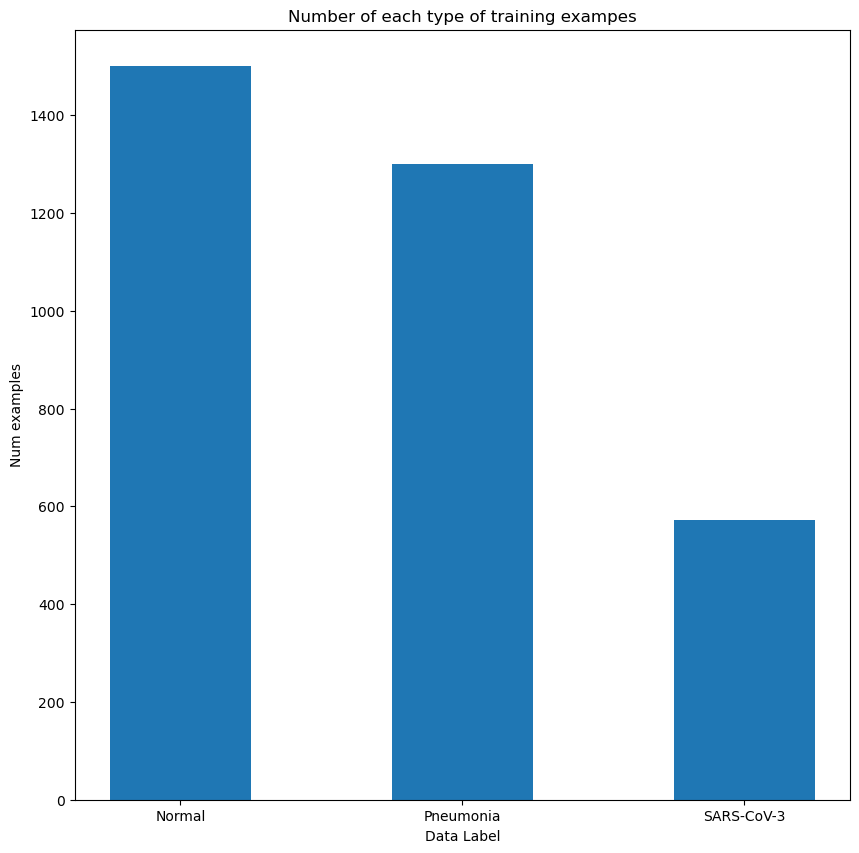

In [9]:
# Plots a bar chart

# YOUR CODE HERE
vals = [counts['normal'], counts['pneumonia'], counts['sarscov3']]
keys = ['Normal', 'Pneumonia', 'SARS-CoV-3']

fig = figure(figsize=(10,10))
bar(x=keys, height=vals, width=0.5, bottom=0)
xlabel("Data Label")
ylabel("Num examples")
title("Number of each type of training exampes")


❓ ***Question: Is the data balanced or not? If not, specify why class imbalance makes classification more difficult, and suggest one method you could use to deal with the imbalanced data.***

📝 No, the dataset is not balanced. There are far more examples of normal and pneumonia than SARS-Cov3. Using data augmentation to create additional training examples from the limited dataset is a good way to deal with the imbalance.

## Part 2: Applying pre-trained CNN models to the data

Researchers make pre-trained neural networks available to the community at large. There are many, many pre-trained CNNs available in online repositories that researchers can leverage for their own applications.

In [10]:
from torchvision.io import read_image
from timm import create_model
from matplotlib.pyplot import imread, imshow
from imagenet_stubs.imagenet_2012_labels import label_to_name
import torch

c:\Users\googl\microconda\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Step 1:** Display the image `SYSC4415W23_A2_dataset/training/sarscov3/100_sarscov3.jpg` from the test set. The matplotlib methods `imread` and `imshow` are useful. 😉

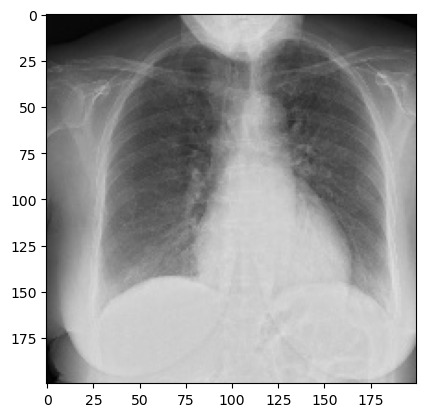

In [11]:
# Display the image with matplotlib's imread/imshow

# YOUR CODE HERE
pic = imread(f"{datasetPath}//training//sarscov3//100_sarscov3.jpg")
imshow(pic)

**Step 2:** Load the ImageNet-pretrained InceptionV3 (`inception_v3`) and ResNet50 (`resnet50`) models with `timm` (this was done in Anthony's CIFAR100 tutorial with PyTorch). Use them to predict the class of the image along with the probability (not the logit). The probability is the result of applying the softmax function to the logits.

Of course, because the models were pretrained on ImageNet, it will not predict any of the classes that interest us.

***Notes:**
1. The `read_image` function can convert an image on disk to a tensor.

2. The function `label_to_name` that I imported for you converts the index of an ImageNet class to its English name.

In [12]:
# Loads the image in a Tensor (the method read_image can load the image in a tensor), calls unsqueeze(0) on the tensor to add a dimension and convert its entries to floats using the .float() method

# YOUR CODE HERE

imgTensor = read_image(f"{datasetPath}\\training\\sarscov3\\100_sarscov3.jpg")

In [13]:
# Loads the InceptionV3 model predicted class along with its probability

# YOUR CODE HERE
inception = create_model(model_name='inception_v3', pretrained=True)
inception.cuda()

print("Done!")

Done!


In [14]:
# Loads the ResNet50 model predicted class along with its probability

# YOUR CODE HERE

resnet = create_model(model_name='resnet50', pretrained=True)
resnet.cuda()

print("Done!")

Done!


❓ ***Question: What classes are predicted for the two models? Are the models confident? Is it a good thing?***

📝 YOUR ANSWERS GO HERE

## Part 3: Instantiating the dataloaders to perform fine tuning
When working with large image datasets with PyTorch, people often implement a DataLoader to help manage how images are loaded during training. The dataloader can be combined with methods that implement data augmentation by modifying the images with transforms (eg. scaling, rotation, reflection, cropping, etc.). For the most common applications, there are existing data loaders that are perfectly suitable and that users can use instead of defining their own.


In [15]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

**Step 1:** Using the `ImageFolder` strategy to build a dataloader with a batch size of 128 for training. ([This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision) is most helpful.)

You will also want your dataloader for your training set to apply the following data augmentation transforms (documentation available [here](https://pytorch.org/vision/stable/transforms.html)):

1. Random rotation between -10 and 10
2. Random horizontal flip with 40% probability

In [16]:
# Creates the dataset and dataloader that will be used for training

# YOUR CODE HERE
batch_size = 32
d_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(degrees=(-10,10)),
    transforms.ToTensor()
])

trainSet = ImageFolder(root=f"{datasetPath}\\training", transform=d_transform)
workers = 0 if usingColab else 4
trainLoad = DataLoader(dataset=trainSet, batch_size=batch_size, shuffle=1, num_workers=workers)

**Step 2**: Create the dataloaders you will be using for validation and testing. The transform should only convert the images to a tensor. You should not specify a batch size for the test set dataloader.

In [17]:
# Creates the dataloader that will be used for validation

# YOUR CODE HERE
d_transform = transforms.Compose([
    transforms.ToTensor()
])

valSet = ImageFolder(root=f"{datasetPath}\\validation", transform=d_transform)
valLoad = DataLoader(dataset=valSet, batch_size=batch_size, shuffle=1, num_workers=workers)

In [18]:
# Creates the dataloader that will be used testing

# YOUR CODE HERE
testSet = ImageFolder(root=f"{datasetPath}\\test", transform=d_transform)
testLoad = DataLoader(dataset=testSet, batch_size=batch_size, shuffle=1, num_workers=workers)

## Part 4: Fine-tuning existing CNN architectures

The Inception V3 and ResNet50 models you loaded above were trained on ImageNet which is not a medical dataset. In order to leverage these models for our purposes, we need to modify the architecture so that the final classification layer contains an appropriate number of classes and retune the model weights so that the models become suitable for the classification of our x-rays.


In [19]:
from timm import create_model
import time
from matplotlib.pyplot import subplots
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch import no_grad, Tensor

**Step 1:** Using `create_model` from the `timm` package, Load the InceptionV3 and ResNet50 models, replacing the final layer with one appropriate for our purpose (recall that we want to classify x-rays of healthy, pneumonia and SARS-CoV-3 patients). Note that the timm library can assist in replacing the final layer (see [Anthony's tutorial](https://github.com/jrgreen7/SYSC4906/blob/master/W2023/Tutorials/CIFAR100_tutorial_WIP.ipynb)). These are your modified models.

In [20]:
# Loads the InceptionV3 model and replaces the final classification layer with a new dense layer

# YOUR CODE HERE
med_inception = create_model(model_name='inception_v3', num_classes=3, pretrained=True)

print("Done!")

Done!


In [21]:
# Loads the ResNet50 model and replaces the final classification layer with a new dense layer

# YOUR CODE HERE
med_resnet = create_model(model_name='resnet50', pretrained=True)

print("Done!")

Done!


**Step 2:** In a tutorial with Anthony, you have seen that you can convert a base learning rate to an effective learning rate based on the batch size you have selected using the following heuristic:

$$\eta_{eff} = \frac{B\eta_{base}}{256}$$

where $\eta$ is the learning rate and $B$ is the batch size.

Train the final layer modified InceptionV3 and ResNet50 models on your training set. Use the **base** learning rate $\eta_{base}$ of 0.0005.

Use the following settings:

**Epochs:** 25

**Optimizer:** AdamW

**Loss function:** Cross-entropy (it is not required here, but note that using the weight parameter here could help deal with class imbalance)

Implement the training loop yourself. Do not use a package that automates the process. Anthony has demonstrated how to do this and much can be taken from [his example](https://github.com/jrgreen7/SYSC4906/blob/master/W2023/Tutorials/CIFAR100_tutorial_WIP.ipynb).

❗**Important: Make sure you are using a colab gpu and to store the mean training and validation performance/loss at each epoch as you will be plotting them in the next steps.**

In [22]:
# Moves the modified inceptionV3 model to GPU

# YOUR CODE HERE
med_inception.cuda()

InceptionV3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride

In [23]:
# Instantiates the optimizer for the modified InceptionV3 model using the specified effective learning rate

# YOUR CODE HERE
base_lr = 0.0005
lr = (base_lr * batch_size) / 256
opt = AdamW(params=med_inception.parameters(), lr=lr)

In [24]:
# Sets up the loss function for the modified InceptionV3 model

# YOUR CODE HERE
loss_fn = CrossEntropyLoss()

In [26]:
# Fine-tunes the weights in the final layer the modified InceptionV3 model (main learning loop)

# YOUR CODE HERE
epochs = 25
for epoch in range(epochs):
    trainLoss = []
    med_inception.train()
    start = time.time()
    for batch in trainLoad:
        imgs, labels = batch
        imgs = imgs.cuda()
        labels = labels.cuda()

        logits = med_inception(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()

        opt.step()
        opt.zero_grad()
        trainLoss.append(loss.item())

        
    valLoss = []
    med_inception.eval()
    with no_grad():
        for batch in valLoad:
            val_img, val_label = batch
            val_img = val_img.cuda()
            val_label = val_label.cuda()

            logits = med_inception(val_img)
            loss = loss_fn(logits, val_label)
            valLoss.append(loss.item())
    
    train_time = time.time() - start
    meanEpochLoss_val = Tensor(valLoss).mean().item()
    meanEpochLoss_train = Tensor(trainLoss).mean().item()
    print(f"Epoch: {epoch}\tTrain Loss: {meanEpochLoss_train}\tVal Loss: {meanEpochLoss_val}\tTime: {train_time}")

Epoch: 0	Train Loss: 0.23396320641040802	Val Loss: 0.2518822252750397	Time: 65.01913022994995
Epoch: 1	Train Loss: 0.14427326619625092	Val Loss: 0.24875225126743317	Time: 61.1906681060791
Epoch: 2	Train Loss: 0.11825811862945557	Val Loss: 0.22747693955898285	Time: 68.49534797668457
Epoch: 3	Train Loss: 0.13287153840065002	Val Loss: 0.13547982275485992	Time: 84.3218355178833


KeyboardInterrupt: 

In [ ]:
# Moves the modified ResNet50 model to GPU

# YOUR CODE HERE
med_resnet.cuda()

In [ ]:
# Instantiates the optimizer for the modified ResNet50 model

# YOUR CODE HERE
base_lr = 0.0005
lr = (base_lr * batch_size) / 256
opt = AdamW(params=med_resnet.parameters(), lr=lr)

In [ ]:
# Sets up the loss function for the modified ResNet50 model

# YOUR CODE HERE
loss_fn = CrossEntropyLoss()

In [ ]:
# Fine-tunes the weights in the final layer the modified ResNet50 model (main learning loop)

# YOUR CODE HERE
epochs = 25
for epoch in range(epochs):
    trainLoss = []
    med_resnet.train()
    start = time.time()
    for batch in trainLoad:
        imgs, labels = batch
        imgs = imgs.cuda()
        labels = labels.cuda()

        logits = med_resnet(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()

        opt.step()
        opt.zero_grad()
        trainLoss.append(loss.item())

        
    valLoss = []
    med_resnet.eval()
    with no_grad():
        for batch in valLoad:
            val_img, val_label = batch
            val_img = val_img.cuda()
            val_label = val_label.cuda()

            logits = med_resnet(val_img)
            loss = loss_fn(logits, val_label)
            valLoss.append(loss.item())
    
    train_time = time.time() - start
    meanEpochLoss_val = Tensor(valLoss).mean().item()
    meanEpochLoss_train = Tensor(trainLoss).mean().item()
    print(f"Epoch: {epoch}\tTrain Loss: {meanEpochLoss_train}\tVal Loss: {meanEpochLoss_val}\tTime: {train_time}")

**Step 3:** In different labeled subplots, display the learning curves for each model. Each subplot should display loss on the training set and the validation set (*i.e.* 2 curves per subplot). Use matplotlib.

In [ ]:
# Displays the learning curves (loss) for both models in two separate subplots

# YOUR CODE HERE

❓ ***Question: Comment on your learning curves. What do they tell you?***

📝 YOUR ANSWER GOES HERE

## Part 5: Performance evaluation on a test set

Of course, estimating the performance of your model on unseen data is a key step in machine learning methodology. Here, you will summarize model performance for your InceptionV3 model and ResNet50 model on the test set.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from torch import no_grad

**Step 1:** Iterate through the images in the test set using the test dataloader to make predictions for the test set images and retrieve their actual label (its index). Note that this is done in a way similar to the validation step in the training loop.

Append the predicted class index to a list, the actual labels to another and the probability of the SARS-CoV-3 class to another list.

Do this for both fine-tuned models.

Note that the indices map to the classes as follows:

0: normal

1: pneumonia

2: sarscov3

In [ ]:
# Creates a list of predictions, a list of actual labels and a list of probabilities of the SARS-CoV-3 class for the fine-tuned InceptionV3 model applied to the test set

# YOUR CODE HERE

In [ ]:
# Creates a list of predictions, a list of actual labels and a list of probabilities of the SARS-CoV-3 class for the fine-tuned ResNet50 model applied to the test set

# YOUR CODE HERE

**Step 2:** Show the confusion matrices for both models. The `confusion_matrix` function from scikit-learn I imported for you is useful for this.

In [ ]:
# Creates the confusion matrix for the modified InceptionV3 model

# YOUR CODE HERE

In [ ]:
# Creates the confusion matrix for the modified ResNet50 model

# YOUR CODE HERE

❓ ***Question: Based off these matrices, report the accuracy of the models.***

📝 YOUR ANSWER GOES HERE

**Step 3:** Use the `PrecisionRecallDisplay.from_predictions` methods documented [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.) to plot the precision recall curves for your models. There are three classes, so convert your labels so that it becomes a binary classification scenario, ie. SARS-CoV-3 vs. not-SARS-CoV-3.

In [ ]:
# Plots the PR curves of your fine-tuned InceptionV3 and ResNet50 models 

# YOUR CODE HERE

❓ ***Question: Based off the results you obtained in this section, which model performs best? Why do you think (in 5 sentences or less)?***

📝 YOUR ANSWER GOES HERE

## Part 6: Answering questions from investors ❓

Bfizer has heard about your model and are interested in investing in your technology. However, before they engage in further discussions, they want you to answer the following questions:

1. Briefly provide techniques that you would explore next to further improve the performance of your model?

2. A competitor has trained an SVM on the same dataset but performs worse than your model. Why do CNNs perform better than SVM for image classification? Discuss two aspects: differences in features and differences in training data.

3. The investors consider investing in a very small device that can run your model. Would your best model fit on this small cost-effective device with 32 MB of storage, assuming that all parameters in the model are 16 bit floats (you can ignore everything in the model but the trainable parameters)? You can use the `torchstat` library ([link](https://github.com/Swall0w/torchstat)) to get the number of parameters. Note that the relevant function from this library was already imported for you (below).

4. If your best model predict a positive SARS-CoV-3 case, how likely is it that you are correct? How likely is it that you are wrong?

5. Assuming that the test data is representative of the disease status among the general population of Canada (it is not, why? hint: think of bias.), how many Canadians (Canada pop: 38M) currently have SARS-CoV-4? How much will it cost Canadians to inject all infected people if one dose of Greenraza™️ can be purchased for 13 CAD (Canadian Dollars)? How many people have pneumonia and need to be isolated? (Show your calculations.)

**Note: Your confusion matrices might be useful for the last 2 questions. 😉**

📝 YOUR SHORT ANSWERS GO HERE (add code cells below as needed for calculations, eg. for running the `stat` function from the `torchstat` package)

In [ ]:
# Determines the number of trainable parameters in your best model
from torchstat import stat

# YOUR CODE HERE

See? It wasn't that hard, was it?! 😉